In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cv2

In [2]:
image_dir = 'mask_dataset'
data=[]
labels=[]
image_paths = os.listdir(image_dir)

for dirName in image_paths:
    dirPath = os.path.join(image_dir, dirName)
    images = os.listdir(dirPath)
    for img in images:
        face = load_img(os.path.join(dirPath, img), target_size=(224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        data.append(face)
        labels.append(dirName)



C:\Users\laxman\miniconda3\envs\majorproject\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [3]:
data = np.array(data, dtype='float32')
labels = np.array(labels, dtype='str')

In [5]:
data.shape

(3833, 224, 224, 3)

In [6]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [7]:
train_X,test_X,train_Y,test_Y=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=10)

In [8]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

In [9]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

9412608/9406464 [==============================] - 15s 2us/step


In [10]:
print(baseModel.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [11]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)

model=Model(inputs=baseModel.input,outputs=headModel)

In [12]:
for layer in baseModel.layers:
    layer.trainable=False


print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [13]:
learning_rate=0.001
Epochs = 20
BS=12

In [14]:
opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [15]:
H=model.fit(
    aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(test_X,test_Y),
    validation_steps=len(test_X)//BS,
    epochs=Epochs
)

Epoch 1/20
255/255 [==============================] - 95s 373ms/step - loss: 0.1812 - accuracy: 0.9286 - val_loss: 0.0657 - val_accuracy: 0.9804
Epoch 2/20
255/255 [==============================] - 79s 309ms/step - loss: 0.0910 - accuracy: 0.9669
Epoch 3/20
255/255 [==============================] - 77s 302ms/step - loss: 0.0908 - accuracy: 0.9676
Epoch 4/20
255/255 [==============================] - 77s 300ms/step - loss: 0.0671 - accuracy: 0.9794
Epoch 5/20
255/255 [==============================] - 77s 301ms/step - loss: 0.0688 - accuracy: 0.9745
Epoch 6/20
255/255 [==============================] - 80s 313ms/step - loss: 0.0646 - accuracy: 0.9787
Epoch 7/20
255/255 [==============================] - 80s 314ms/step - loss: 0.0427 - accuracy: 0.9840
Epoch 8/20
255/255 [==============================] - 80s 315ms/step - loss: 0.0473 - accuracy: 0.9846
Epoch 9/20
255/255 [==============================] - 80s 315ms/step - loss: 0.0509 - accuracy: 0.9817
Epoch 10/20
255/255 [==========

In [16]:
model.save('mobilenet_v2.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mobilenet_v2.model\assets


In [17]:
predict=model.predict(test_X,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_Y.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



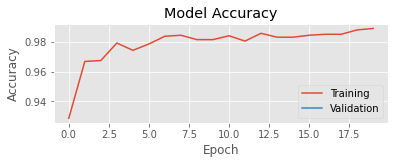

In [34]:
N = Epochs
plt.subplot(211)
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

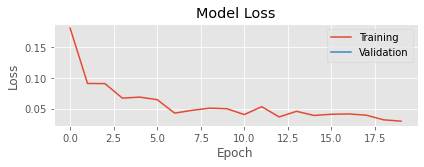

In [39]:
plt.subplot(212)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()

In [48]:
from sklearn.metrics import confusion_matrix

In [93]:
test_Y.shape

(767, 2)

In [94]:
predict.shape

(767,)

In [95]:
pred = to_categorical(predict)

In [96]:
pred.shape

(767, 2)

In [98]:
pred.argmax(axis=1)

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,

In [102]:
test_Y.argmax(axis=1)

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,

In [106]:
conf_mat = confusion_matrix(test_Y.argmax(axis=1), pred.argmax(axis=1))

<AxesSubplot:>

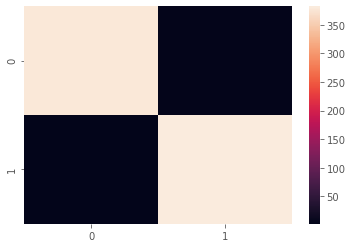

In [107]:
import seaborn as sns
sns.heatmap(conf_mat)

In [112]:
test_X[0].shape

(224, 224, 3)